## Import Data 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os 

dir_path = os.getcwd()
cifar10_dataset_folder = '/dataset/cifar-10-batches-py/'
cifar10_dataset_folder_path = dir_path + cifar10_dataset_folder

print(cifar10_dataset_folder_path)

/tf/notebooks/dataset/cifar-10-batches-py/


In [2]:
def unpickle(file, encoding='bytes'):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding=encoding)
    return dict

batches_meta = unpickle(cifar10_dataset_folder_path+'batches.meta', encoding='utf-8')
label_names = batches_meta['label_names']

def load_label_names():
    return label_names

In [3]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + 'data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore Data


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


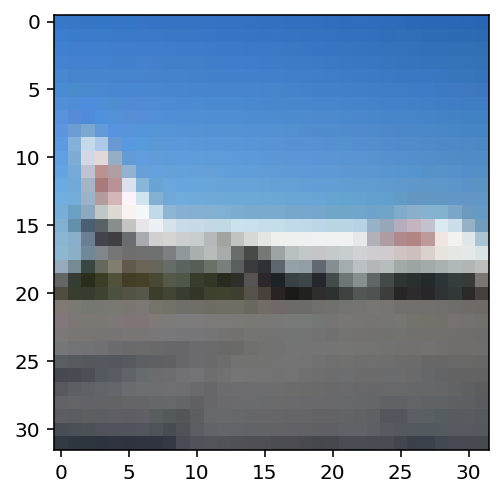

In [4]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)
    
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocessing

In [5]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [6]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [7]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    with open(filename, 'wb') as file:
        pickle.dump((features, labels), file)


In [8]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             cifar10_dataset_folder_path+'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         cifar10_dataset_folder_path + 'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         cifar10_dataset_folder_path + 'preprocess_training.p')

In [9]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [10]:
import pickle

valid_features, valid_labels = pickle.load(open(cifar10_dataset_folder_path+'preprocess_validation.p', mode='rb'))

## Model

In [11]:
import tensorflow as tf

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

### Hyperparameter

In [12]:
import tensornets as nets

epochs = 7
batch_size = 32
learning_rate = 0.00001


logits = nets.VGG19(x, is_training=True, classes=10)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.losses.softmax_cross_entropy(y, logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

W0626 06:43:01.906624 139983626991424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensornets/utils.py:238: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0626 06:43:02.187267 139983626991424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensornets/utils.py:279: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0626 06:43:02.518624 139983626991424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0626 06:43:03.104386 139983626991424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensornets/utils.py:246: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph

In [13]:
logits.print_outputs()


Scope: vgg19
conv1/1/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/1/Relu:0 (?, 224, 224, 64)
conv1/2/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/2/Relu:0 (?, 224, 224, 64)
conv1/pool/MaxPool:0 (?, 112, 112, 64)
conv2/1/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/1/Relu:0 (?, 112, 112, 128)
conv2/2/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/2/Relu:0 (?, 112, 112, 128)
conv2/pool/MaxPool:0 (?, 56, 56, 128)
conv3/1/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/1/Relu:0 (?, 56, 56, 256)
conv3/2/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/2/Relu:0 (?, 56, 56, 256)
conv3/3/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/3/Relu:0 (?, 56, 56, 256)
conv3/4/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/4/Relu:0 (?, 56, 56, 256)
conv3/pool/MaxPool:0 (?, 28, 28, 256)
conv4/1/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/1/Relu:0 (?, 28, 28, 512)
conv4/2/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/2/Relu:0 (?, 28, 28, 512)
conv4/3/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/3/Relu:0 (?, 28, 28, 512)
conv4/4/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/4/Relu:0 (?, 28, 28, 5

In [14]:
logits.print_summary()

W0626 06:43:03.848137 139983626991424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensornets/utils.py:99: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



Scope: vgg19
Total layers: 19
Total weights: 114
Total parameters: 418,833,630


In [15]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = cifar10_dataset_folder_path+'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    tmpFeatures = []
    
    for feature in features:
        tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
        tmpFeatures.append(tmpFeature)

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(tmpFeatures, labels, batch_size)

### Get inputs for validation

In [16]:
import skimage
import skimage.io
import skimage.transform

tmpValidFeatures = []

for feature in valid_features:
    tmpValidFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpValidFeatures.append(tmpValidFeature)
    
tmpValidFeatures = np.array(tmpValidFeatures)

In [17]:
print(tmpValidFeatures.shape)

(5000, 224, 224, 3)


In [18]:
import time
save_model_path = './model/'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    start_time = time.time()
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(optimizer, {x: batch_features, y: batch_labels})
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(tmpValidFeatures, valid_labels, batch_size):
                valid_acc += sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels})
            
            tmp_num = tmpValidFeatures.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)


Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.460600
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.620200
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.702000
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.734800
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.739800
Time elapsed: 10.50 min
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.748600
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.768200
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.819600
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.852800
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.842000
Time elapsed: 20.95 min
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.863800
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.883000
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.874200
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.872200
Epoch  3, CIFAR-10 Batch 5:  Validation A

In [19]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
#         print('image_i: ', image_i)
#         print('axs: ', axs, ', axs len: ', len(axs))
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

In [22]:
test_features, test_labels = pickle.load(open(cifar10_dataset_folder_path+'preprocess_validation.p', mode='rb'))
tmpFeatures = []

for feature in test_features:
    tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpFeatures.append(tmpFeature)

tmpFeatures = np.asarray(tmpFeatures)

W0626 08:02:29.188629 139983626991424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Testing Accuracy: 0.9044699367088608

[0] ground truth: horse, predicted result: horse | True
	- [{'airplane': 0.085336745}, {'automobile': 0.085336745}, {'bird': 0.085336745}, {'cat': 0.085336745}, {'deer': 0.085336745}, {'dog': 0.085336745}, {'frog': 0.085336745}, {'horse': 0.23196931}, {'ship': 0.085336745}, {'truck': 0.085336745}]

[1] ground truth: frog, predicted result: frog | True
	- [{'airplane': 0.085336745}, {'automobile': 0.085336745}, {'bird': 0.085336745}, {'cat': 0.085336745}, {'deer': 0.085336745}, {'dog': 0.085336745}, {'frog': 0.23196931}, {'horse': 0.085336745}, {'ship': 0.085336745}, {'truck': 0.085336745}]

[2] ground truth: dog, predicted result: bird | False
	- [{'airplane': 0.08886977}, {'automobile': 0.08887188}, {'bird': 0.15237914}, {'cat': 0.12780692}, {'deer': 0.090157464}, {'dog': 0.094338216}, {'frog': 0.09096703}, {'horse': 0.08886979}, {'ship': 0.08886996}, {'truck': 0.08886982}]

[3] ground truth: bird, predicted result: bird | True
	- [{'airplane': 0.

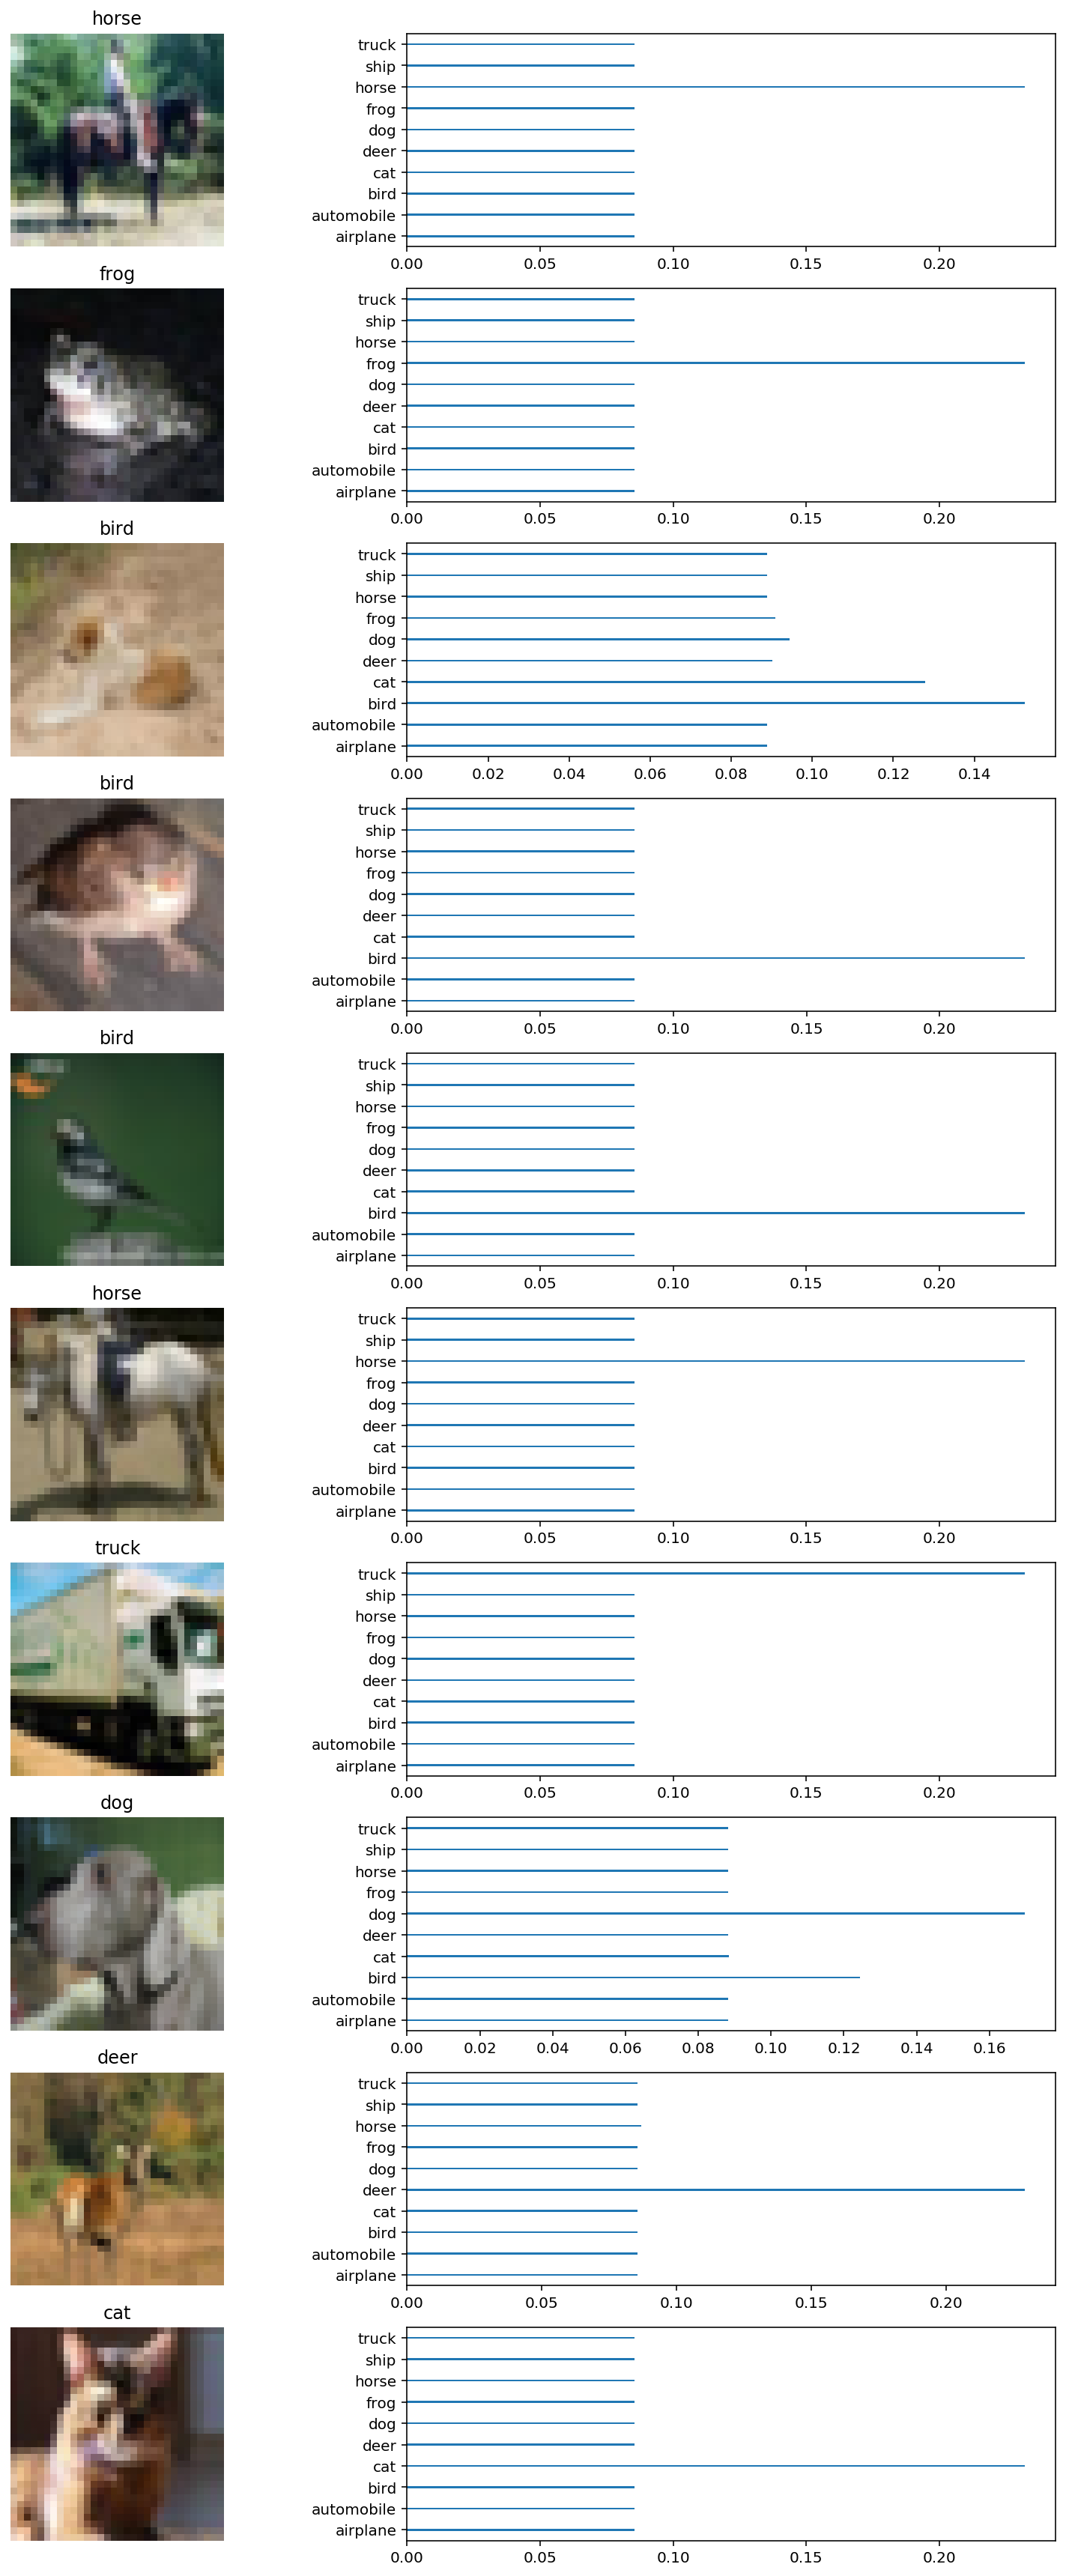

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './model/'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(tmpFeatures, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)